In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")
rc = {'font.sans-serif': 'SimHei', 'axes.unicode_minus': False}
sns.set(context="talk", style="ticks", rc=rc)
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [15]:
file_path = '附件1 近5年402家供应商的相关数据.xlsx'

order_df = pd.read_excel(file_path, sheet_name='企业的订货量（m³）')
supply_df = pd.read_excel(file_path, sheet_name='供应商的供货量（m³）')

order_df.head()

,供应商ID,材料分类,W001,W002,W003,W004,W005,W006,W007,W008,...,W231,W232,W233,W234,W235,W236,W237,W238,W239,W240
0,S001,B,0,0,0,43,0,0,0,0,...,1,0,0,1,0,1,0,0,0,0
1,S002,A,1,1,0,1,0,0,0,0,...,0,0,1,0,0,0,1,1,0,1
2,S003,C,7,1,0,0,0,1,4,50,...,10,3,50,20,20,7,10,9,20,10
3,S004,B,0,1,1,100,0,85,0,0,...,1,0,1,0,0,0,0,1,0,0
4,S005,A,30,60,60,60,70,70,60,70,...,80,70,70,70,70,70,70,70,70,80


In [16]:
top_50_suppliers = pd .read_excel("TOPSIS前50家供应商.xlsx")
top_50_ids = top_50_suppliers['供应商编号'].head(50).tolist()

# SARIMA

In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


def predict_supplier_supply_next_24_weeks(supplier_id, supply_df, plot=True):
    row = supply_df[supply_df.iloc[:, 0] == supplier_id]
    if row.empty:
        raise ValueError(f"未在供货量表中找到供应商 {supplier_id}")
    supply_series = row.iloc[0, 2:].astype(float).values
    weeks = pd.date_range(start='2017-01-01', periods=len(supply_series), freq='W')
    supply_ts = pd.Series(supply_series, index=weeks)
    order = (1, 1, 1) 
    seasonal_order = (1, 1, 1, 48)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = SARIMAX(supply_ts, order=order, seasonal_order=seasonal_order)
        results = model.fit(disp=False)

    forecast = results.get_forecast(steps=24)
    predicted_supply = forecast.predicted_mean.values
    predicted_supply = np.where(predicted_supply < 0, 0, predicted_supply).astype(int)
    if plot:
        plt.figure(figsize=(12, 6))
        plt.plot(supply_ts[-100:], label='历史供货量', marker='o', markersize=3)
        future_index = pd.date_range(start=supply_ts.index[-1], periods=25, freq='W')[1:]
        plt.plot(future_index, forecast.predicted_mean, label='预测供货量', color='r', linestyle='--', marker='x', markersize=4)
        pred_ci = forecast.conf_int()
        plt.fill_between(future_index,
                         pred_ci.iloc[:, 0], pred_ci.iloc[:, 1],
                         color='pink', alpha=0.3, label='95% 置信区间')
        plt.title(f'供应商 {supplier_id} 的供货量预测')
        plt.xlabel('时间')
        plt.ylabel('供货量 ($m^3$)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return predicted_supply

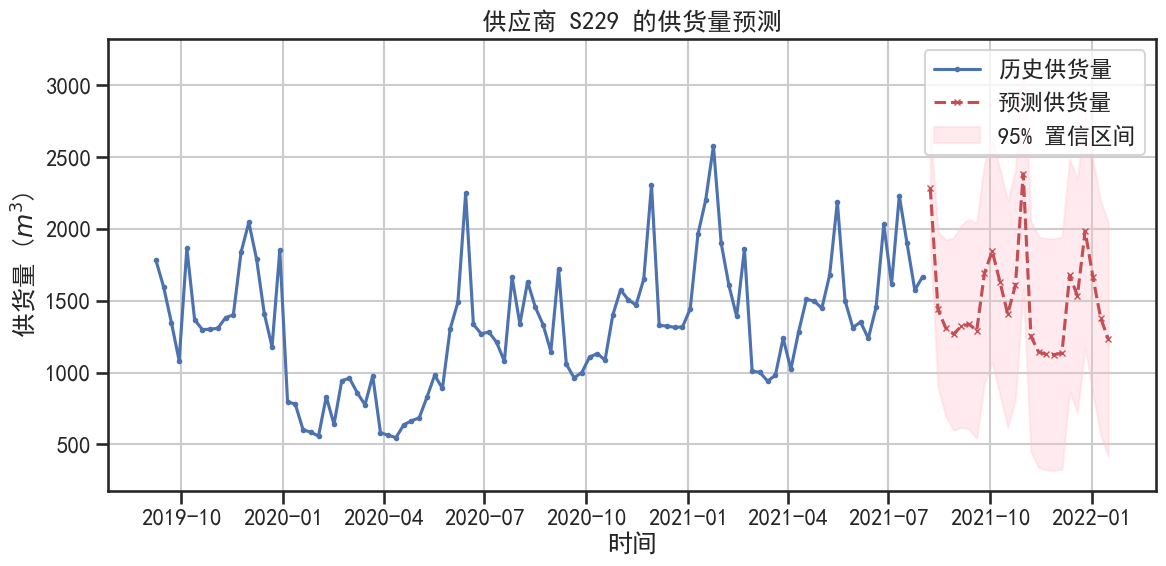

S229未来 24周供货量预测结果： [2285 1439 1309 1267 1321 1336 1291 1691 1844 1630 1406 1609 2382 1251
 1142 1126 1124 1134 1676 1534 1984 1666 1379 1230]


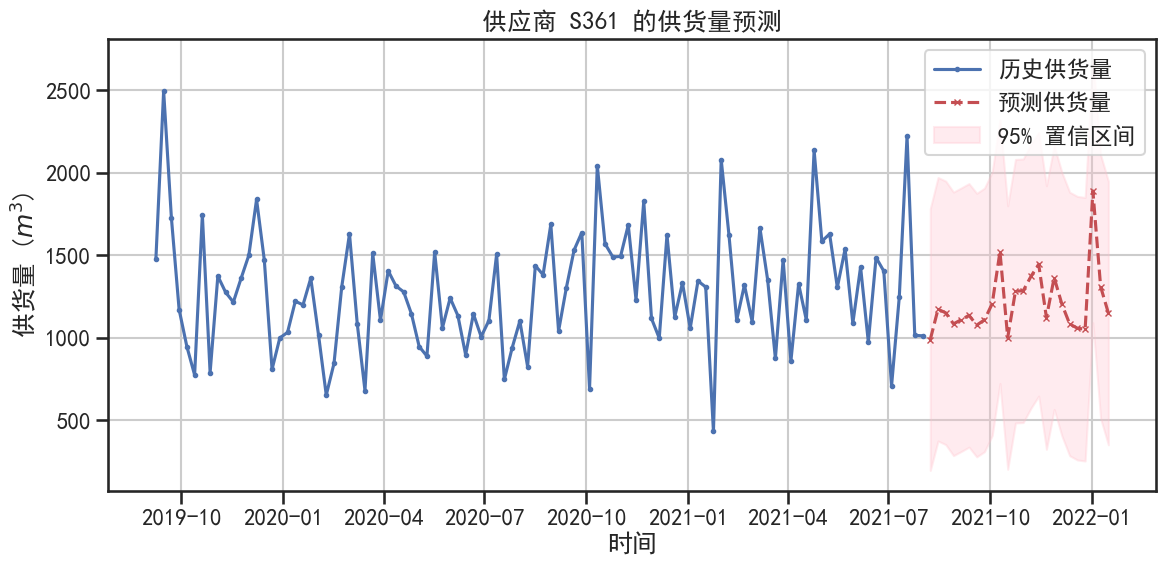

S361未来 24周供货量预测结果： [ 989 1173 1151 1084 1109 1136 1077 1108 1206 1521 1001 1282 1284 1371
 1445 1122 1364 1203 1083 1058 1051 1889 1309 1149]


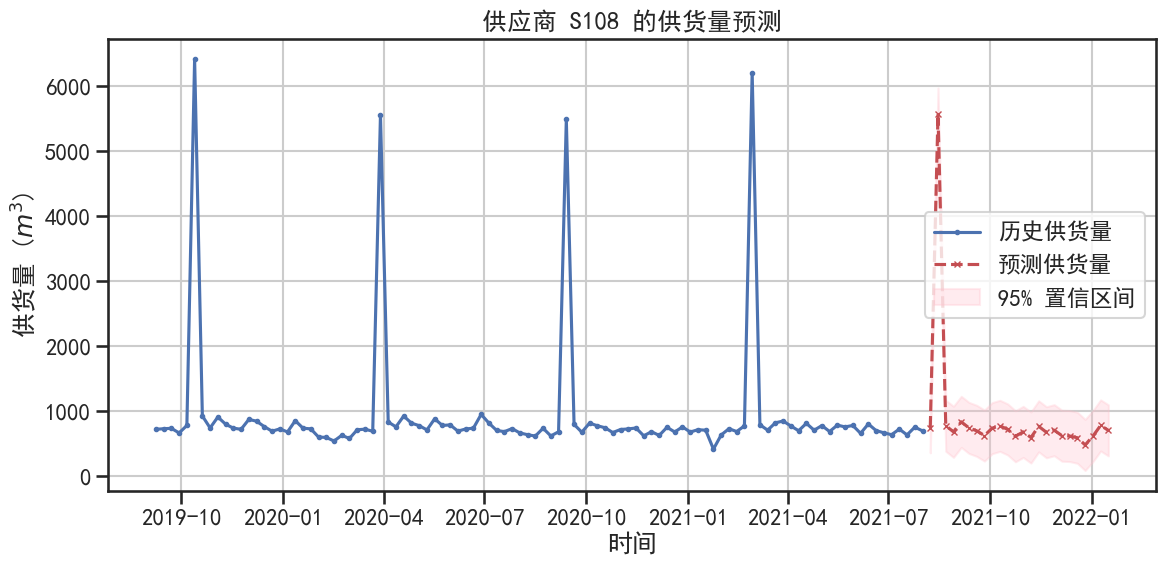

S108未来 24周供货量预测结果： [ 748 5580  776  682  837  743  698  626  740  775  719  614  682  595
  767  676  708  624  618  592  481  616  781  705]


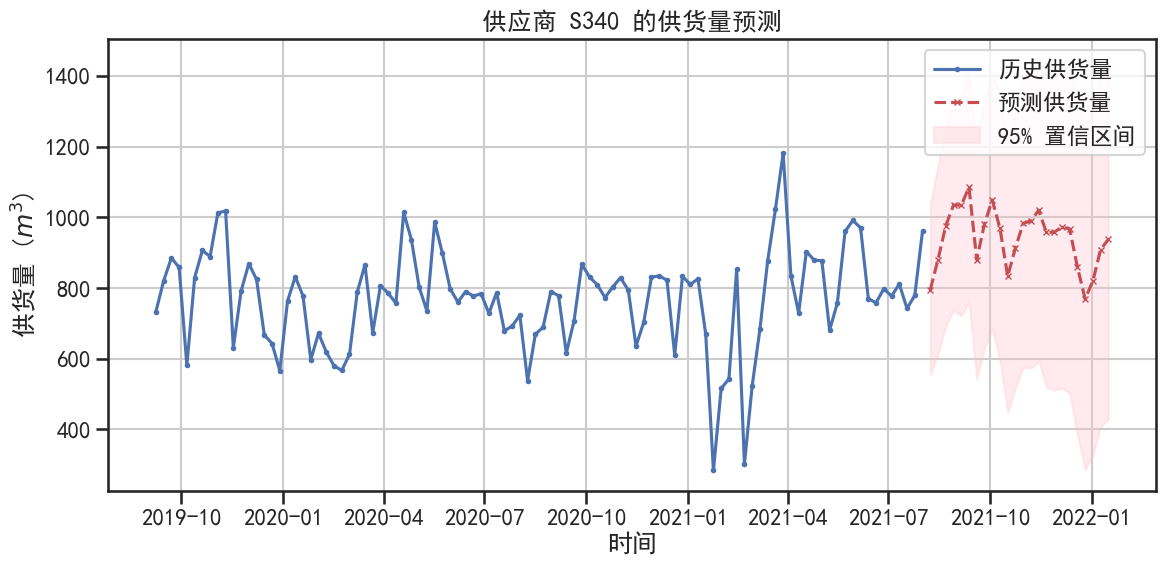

S340未来 24周供货量预测结果： [ 794  880  975 1034 1033 1084  880  981 1048  968  833  913  982  989
 1019  957  957  972  966  859  769  819  908  937]


In [6]:
for i in range(4):
    supplier_id = top_50_ids[i]
    forecast_supply = predict_supplier_supply_next_24_weeks(supplier_id, supply_df)
    print(f"{ supplier_id}未来 24周供货量预测结果：", forecast_supply)

## 预测TOP50供货商的供货量

In [12]:
future_weeks = [f'W{i}' for i in range(241, 265)]  # W241~W264
result_df = pd.DataFrame(columns=['供应商编号', '材料分类'] + future_weeks)

top_50_ids = top_50_suppliers['供应商编号'].tolist()
top_50_supply_sorted = pd.DataFrame()

for supplier_id in top_50_ids:
    match_row = supply_df[supply_df.iloc[:, 0] == supplier_id]
    if not match_row.empty:
        top_50_supply_sorted = pd.concat([top_50_supply_sorted, match_row], ignore_index=True)

for idx in tqdm(range(len(top_50_supply_sorted)), desc="预测供应商供货量"):
    row = top_50_supply_sorted.iloc[idx]
    supplier_id = row.iloc[0]
    category = row.iloc[1]

    try:
        prediction = predict_supplier_supply_next_24_weeks(supplier_id, supply_df,  plot=False)
        new_row = pd.DataFrame([[
            supplier_id,
            category,
            *prediction.tolist()
        ]], columns=result_df.columns)

        result_df = pd.concat([result_df, new_row], ignore_index=True)

    except Exception as e:
        print(f"error: {e}")

预测供应商供货量: 100%|██████████| 50/50 [05:35<00:00,  6.70s/it]


In [13]:
result_df.to_excel("供应商供货量预测结果.xlsx", index=False) # 保存

# SARIMA订货量（ABC）

In [17]:
week_columns = [f'W{i:03d}' for i in range(1, 241)]
abc_order_data = order_df.groupby('材料分类')[week_columns].sum().loc[['A', 'B', 'C']]
weeks = pd.date_range(start='2017-01-01', periods=240, freq='W')
abc_order_ts = pd.DataFrame({
    'A': abc_order_data.loc['A'].values,
    'B': abc_order_data.loc['B'].values,
    'C': abc_order_data.loc['C'].values
}, index=weeks)

In [18]:
abc_order_ts

,A,B,C
2017-01-01,5745,8322,4425
2017-01-08,3476,10939,4889
2017-01-15,2902,10828,5162
2017-01-22,5550,6363,6806
2017-01-29,4031,19436,4240
...,...,...,...
2021-07-04,7936,4549,6213
2021-07-11,6555,3368,29184
2021-07-18,5639,3142,19132
2021-07-25,5386,3271,10470


In [43]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def predict_weekly_order_for_category(ts_series, steps=24, order=(1, 1, 1), seasonal_order=(2, 1, 1, 48)):
    model = SARIMAX(ts_series, order=order, seasonal_order=seasonal_order)
    result = model.fit(disp=False)
    forecast = result.get_forecast(steps=steps)
    predicted_mean = forecast.predicted_mean.values
    predicted_mean = np.where(predicted_mean < 0, 0, predicted_mean)  # 替换负值为0
    return forecast.predicted_mean, forecast.conf_int()

In [44]:
warnings.filterwarnings("ignore")
future_weeks = pd.date_range(start=weeks[-1] + pd.Timedelta(days=7), periods=24, freq='W')
predicted_means = {}
conf_ints = {}

for category in ['A', 'B', 'C']:
    mean, ci = predict_weekly_order_for_category(abc_order_ts[category], steps=24)
    predicted_means[category] = mean.values
    conf_ints[category] = ci.values

predicted_df = pd.DataFrame({f'{cat}类预测订货量': predicted_means[cat] for cat in ['A', 'B', 'C']}, index=future_weeks)
new_index = [f"W{i}" for i in range(241, 265)]
predicted_df["Week"] = new_index
print(predicted_df)
predicted_df.to_excel("预测订货量结果.xlsx", index=False)

                 A类预测订货量       B类预测订货量       C类预测订货量  Week
2021-08-08   6629.940362  26211.924104   9321.066568  W241
2021-08-15   9351.314320  10900.585938   8664.049586  W242
2021-08-22   3505.683116  12823.655304   9483.745336  W243
2021-08-29   7000.331804  10647.890331   8922.509858  W244
2021-09-05   4156.916101  21913.195887   8009.364333  W245
2021-09-12   9014.905569   5063.066412   8370.965464  W246
2021-09-19  11269.777264   8298.737068   9080.181949  W247
2021-09-26   6870.163993   9738.798144   9352.137132  W248
2021-10-03   6042.388790  14288.827855   9322.746170  W249
2021-10-10  14640.297393   9097.418288  10453.602355  W250
2021-10-17   6183.845870   5509.906701  12248.060365  W251
2021-10-24   7713.085655   6019.879310  12477.980362  W252
2021-10-31   7832.005213  11639.691519  10812.308666  W253
2021-11-07   6202.374517   4505.185428  11390.615427  W254
2021-11-14   5415.117212   5893.805815  12333.358356  W255
2021-11-21   6586.568615  12632.270703  10476.824836  W2

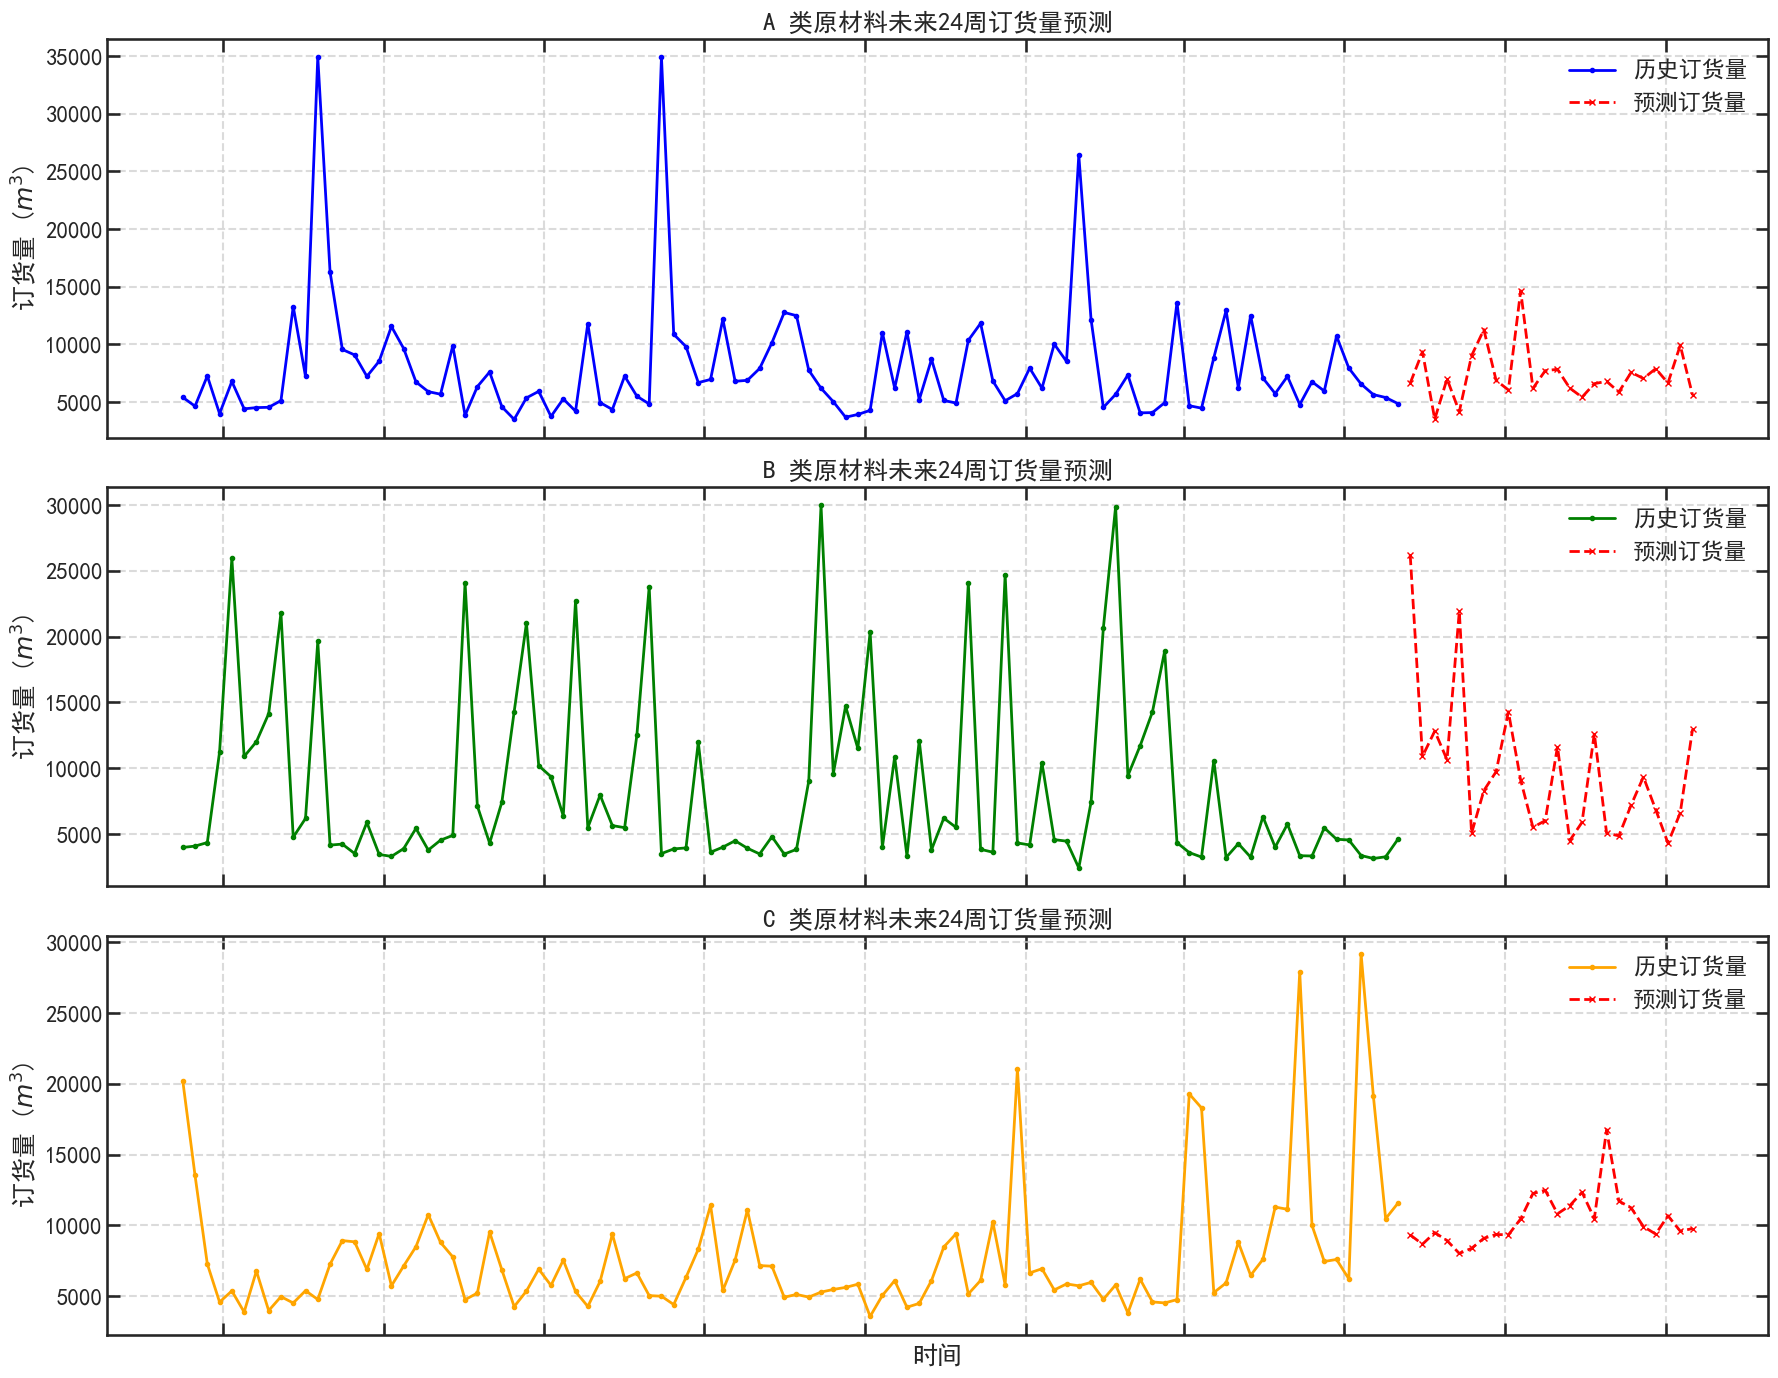

In [45]:
plt.rcParams.update({
    'font.size': 14,
    'lines.linewidth': 2,
    'lines.markersize': 6,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.top': True,
    'ytick.right': True,
    'axes.spines.top': True,
    'axes.spines.right': True,
    'legend.frameon': False,
    'axes.grid': True,
    'grid.linestyle': '--',
    'grid.alpha': 0.7
})
fig, axes = plt.subplots(3, 1, figsize=(18, 14), sharex=True)
colors = {'A': 'blue', 'B': 'green', 'C': 'orange'}
categories = ['A', 'B', 'C']

for ax, category in zip(axes, categories):
    ax.plot(abc_order_ts.index[-100:], abc_order_ts[category][-100:], label='历史订货量', color=colors[category], marker='o', markersize=3)
    future_index = predicted_df.index
    ax.plot(future_index, predicted_df[f'{category}类预测订货量'], label='预测订货量', color='red', linestyle='--', marker='x', markersize=5)

    ax.set_title(f'{category} 类原材料未来24周订货量预测')
    ax.set_ylabel('订货量 ($m^3$)')
    ax.legend()
    ax.grid(True)
    ax.xaxis.set_ticklabels([])

plt.xlabel("时间")
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

# 平均损耗量曲线

In [19]:
loss_df = pd.read_excel("附件2 近5年8家转运商的相关数据.xlsx")
week_columns = [f'W{i:03d}' for i in range(1, 241)]
loss_data = loss_df[week_columns].values.T
weeks = pd.date_range(start='2017-01-01', periods=240, freq='W')
loss_ts = pd.DataFrame(loss_data, index=weeks, columns=loss_df['转运商ID'])
weekly_avg_loss = loss_ts.mean(axis=1)
avg_loss_series = pd.Series(weekly_avg_loss.values, index=weekly_avg_loss.index)

mean = avg_loss_series.mean()
std = avg_loss_series.std()
lower_bound = mean - 3 * std
upper_bound = mean + 3 * std
outliers = (avg_loss_series < lower_bound) | (avg_loss_series > upper_bound) # 超过标准差3倍的点，认为是异常值
cleaned_series = avg_loss_series.copy()
cleaned_series[outliers] = mean

In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def sarima_forecast(ts_series, steps=24):
    order = (1, 1, 1)
    seasonal_order = (1, 1, 1, 48)
    model = SARIMAX(ts_series, order=order, seasonal_order=seasonal_order)
    result = model.fit(disp=False)
    forecast = result.get_forecast(steps=steps)
    predicted_mean = forecast.predicted_mean.values
    return predicted_mean

predicted_loss = sarima_forecast(cleaned_series, steps=24)

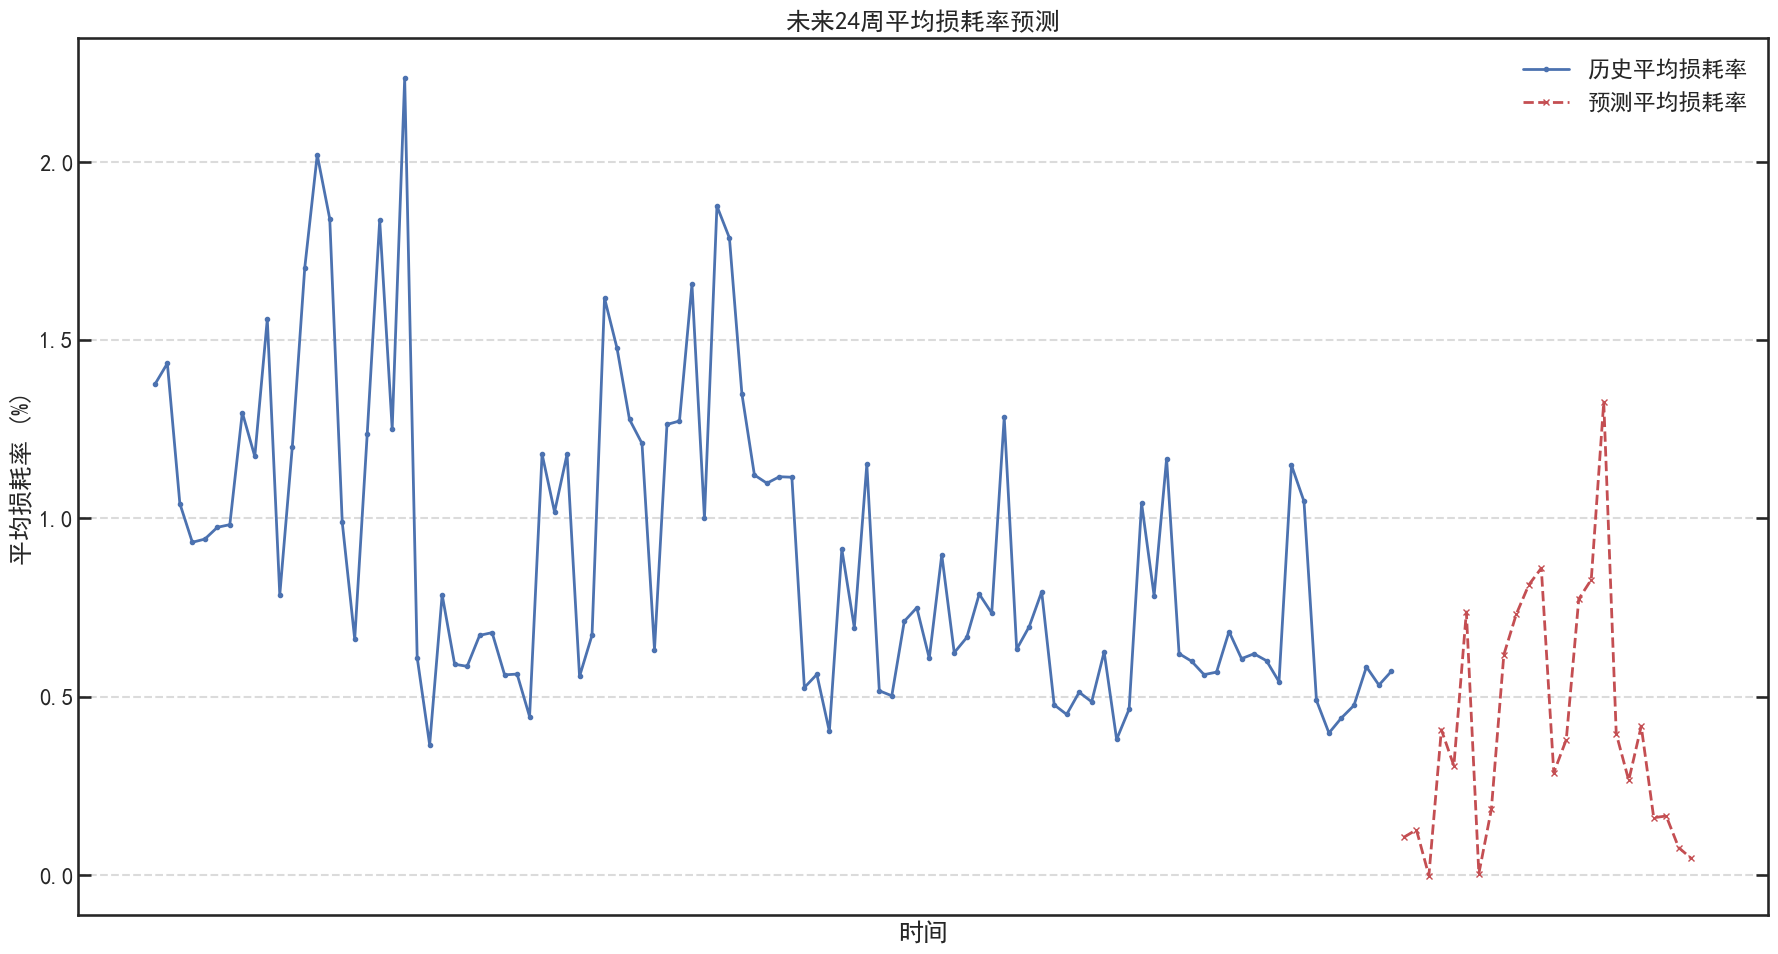

    Week  预测平均损耗率 (%)
0   W241     0.105230
1   W242     0.126325
2   W243    -0.002182
3   W244     0.406800
4   W245     0.306012
5   W246     0.737297
6   W247     0.003232
7   W248     0.183151
8   W249     0.617434
9   W250     0.731347
10  W251     0.813538
11  W252     0.860246
12  W253     0.286387
13  W254     0.379258
14  W255     0.773695
15  W256     0.828168
16  W257     1.326219
17  W258     0.395572
18  W259     0.264963
19  W260     0.417006
20  W261     0.160060
21  W262     0.164877
22  W263     0.076114
23  W264     0.046109


In [28]:
plt.rcParams.update({
    'font.size': 14,
    'lines.linewidth': 2,
    'lines.markersize': 6,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.top': True,
    'ytick.right': True,
    'axes.spines.top': True,
    'axes.spines.right': True,
    'legend.frameon': False,
    'axes.grid': True,
    'grid.linestyle': '--',
    'grid.alpha': 0.7
})

future_index = pd.date_range(start=weeks[-1] + pd.Timedelta(days=7), periods=24, freq='W')

plt.figure(figsize=(18, 10))
plt.plot(cleaned_series[-100:], label='历史平均损耗率', marker='o', markersize=3)
plt.plot(future_index, predicted_loss, label='预测平均损耗率', color='r', linestyle='--', marker='x', markersize=5)

plt.title("未来24周平均损耗率预测")
plt.xlabel("时间")
plt.ylabel("平均损耗率 (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks([])
plt.show()

new_index = [f"W{i}" for i in range(241, 265)]
loss_predicted_df = pd.DataFrame({
    'Week': new_index,
    '预测平均损耗率 (%)': predicted_loss
})
print(loss_predicted_df)

# 遗传算法最优化

In [29]:
df_demand = pd.read_excel("预测订货量结果.xlsx")
demand_A = df_demand["A类预测订货量"].values
demand_B = df_demand["B类预测订货量"].values
demand_C = df_demand["C类预测订货量"].values
loss_rates = loss_predicted_df["预测平均损耗率 (%)"].values
df_suppliers = pd.read_excel("供应商供货量预测结果.xlsx")
supplier_ids = df_suppliers["供应商编号"].tolist()
materials = df_suppliers["材料分类"].tolist()
weeks = [f"W{i}" for i in range(241, 265)]
supply_data = df_suppliers[weeks].values 

In [30]:
def get_supply(individual, week):
    # 计算该个体在第 week 周对 A/B/C 的总供货量
    supply = {"A": 0, "B": 0, "C": 0}
    selected = [i for i in range(50) if individual[i] == 1]
    for idx in selected:
        mat = materials[idx]
        supply[mat] += supply_data[idx][week]
    return supply

In [31]:
get_supply(np.ones(50), 0 )

{'A': 7443, 'B': 26947, 'C': 8580}

In [80]:
sum_supply = supply_data.sum(axis = 0)
sum_demand = df_demand.iloc[:,:-1].sum(axis = 1).values

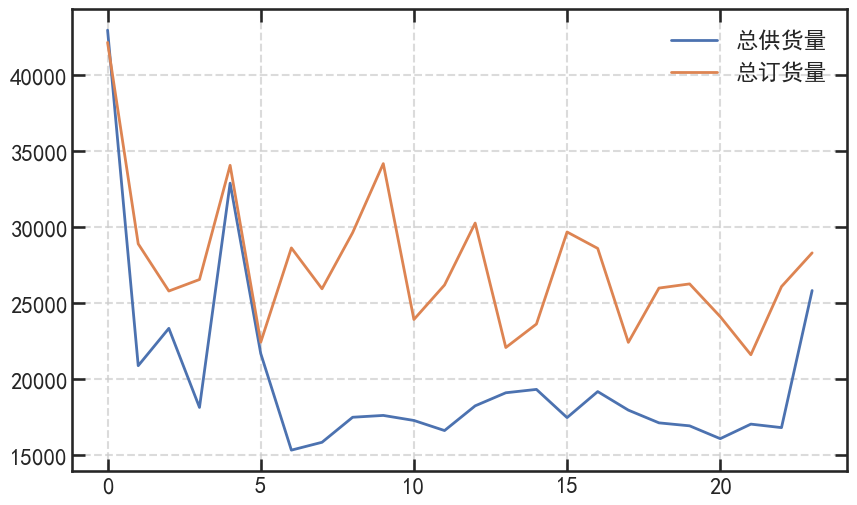

In [83]:
plt.figure(figsize=(10,6))
plt.plot(sum_supply, label="总供货量")
plt.plot(sum_demand, label="总订货量")    
plt.legend()
plt.show()

### 为什么出现了上面的情况？
因为我们的供货商只选择了TOP50，但是订货量是按照所有供货商的订单量累加得到的。一共402家供货商，虽然TOP50供货多，但是剩下352家供货商的也提供了很多供货量！！用50家中选一些来满足原本要402家供货商订货量的需求是肯定不行的。

In [57]:
def fitness(individual, week):
    loss = loss_rates[week]
    demand = {
        "A": demand_A[week],
        "B": demand_B[week],
        "C": demand_C[week]
    }
    # C来代表
    supply = get_supply(individual, week)

    received_A = supply["A"] * (1 - loss)
    received_B = supply["B"] * (1 - loss)
    received_C = supply["C"] * (1 - loss)


    shortage_penalty = 0
    
    if received_A < demand["A"] * 0.9 and received_B < demand["B"] * 0.9 and received_C < demand["C"] * 0.9:
        shortage_penalty += demand["A"] + demand["B"]  + demand["C"] -  received_A - received_B - received_C + 50

    
    if shortage_penalty == 0:
        return sum(individual)  # 成本：供应商数量
    else:
        return shortage_penalty

In [52]:
def genetic_algorithm(week, pop_size=10, generations=500, mutation_rate=0.05):

    print(f"\n=== 开始处理第 {week+1} 周（{weeks[week]}） ===")

    population = np.random.randint(0, 2, size=(pop_size, 50))

    for gen in range(generations):
        scores = np.array([fitness(ind, week) for ind in population])
        
        best_idx = np.argmin(scores)
        best_ind = population[best_idx]
        best_score = scores[best_idx]
        if gen % 10 == 0 or gen == generations - 1:
            print(f"Generation {gen}: 最优适应度 = {best_score:.2f}")

        selected_indices = np.argsort(scores)[:int(pop_size * 0.2)]
        parents = population[selected_indices]

        offspring = []
        while len(offspring) < pop_size:
            p1, p2 = parents[np.random.choice(len(parents), 2, replace=False)]
            crossover_point = np.random.randint(1, 49)
            child = np.concatenate((p1[:crossover_point], p2[crossover_point:]))
            offspring.append(child)

        for i in range(len(offspring)):
            if np.random.rand() < mutation_rate:
                idx = np.random.randint(0, 50)
                offspring[i][idx] ^= 1  # 翻转位

        population = np.array(offspring)

    final_scores = np.array([fitness(ind, week) for ind in population])
    best_idx = np.argmin(final_scores)
    best_individual = population[best_idx]
    num_suppliers = sum(best_individual)
    selected_suppliers = [supplier_ids[i] for i in range(50) if best_individual[i] == 1]

    # print(f"\n✅ 第 {week+1} 周最优解:")
    # print(f"📌 供应商数量: {num_suppliers}")
    # print(f"📌 选中的供应商: {selected_suppliers}")

    return {
        "week": weeks[week],
        "num_suppliers": num_suppliers,
        "selected_suppliers": selected_suppliers
    }
genetic_algorithm(0)


=== 开始处理第 1 周（W241） ===
Generation 0: 最优适应度 = 9819.56
Generation 10: 最优适应度 = 8799.52
Generation 20: 最优适应度 = 8089.08
Generation 30: 最优适应度 = 8089.08
Generation 40: 最优适应度 = 8089.08
Generation 50: 最优适应度 = 6606.44
Generation 60: 最优适应度 = 6460.59
Generation 70: 最优适应度 = 6460.59
Generation 80: 最优适应度 = 6460.59
Generation 90: 最优适应度 = 6444.49
Generation 100: 最优适应度 = 6389.01
Generation 110: 最优适应度 = 5710.78
Generation 120: 最优适应度 = 5554.19
Generation 130: 最优适应度 = 5554.19
Generation 140: 最优适应度 = 5554.19
Generation 150: 最优适应度 = 5554.19
Generation 160: 最优适应度 = 5554.19
Generation 170: 最优适应度 = 5554.19
Generation 180: 最优适应度 = 4766.79
Generation 190: 最优适应度 = 4766.79
Generation 200: 最优适应度 = 4766.79
Generation 210: 最优适应度 = 4629.89
Generation 220: 最优适应度 = 4629.89
Generation 230: 最优适应度 = 4629.89
Generation 240: 最优适应度 = 4629.89
Generation 250: 最优适应度 = 4234.41
Generation 260: 最优适应度 = 46.00
Generation 270: 最优适应度 = 43.00
Generation 280: 最优适应度 = 39.00
Generation 290: 最优适应度 = 36.00
Generation 300: 最优适应度 = 35.00
Gene

{'week': 'W241',
 'num_suppliers': 16,
 'selected_suppliers': ['S229',
  'S340',
  'S282',
  'S275',
  'S329',
  'S352',
  'S143',
  'S307',
  'S395',
  'S284',
  'S086',
  'S114',
  'S291',
  'S007',
  'S266',
  'S273']}

In [58]:
max = 0
for week in range(24):
    list_week = genetic_algorithm(week)
    if len(list_week["selected_suppliers"]) > max:
        max = len(list_week["selected_suppliers"])


=== 开始处理第 1 周（W241） ===
Generation 0: 最优适应度 = 10249.95
Generation 10: 最优适应度 = 9513.55
Generation 20: 最优适应度 = 8104.29
Generation 30: 最优适应度 = 7110.20
Generation 40: 最优适应度 = 37.00
Generation 50: 最优适应度 = 34.00
Generation 60: 最优适应度 = 32.00
Generation 70: 最优适应度 = 30.00
Generation 80: 最优适应度 = 29.00
Generation 90: 最优适应度 = 27.00
Generation 100: 最优适应度 = 27.00
Generation 110: 最优适应度 = 23.00
Generation 120: 最优适应度 = 20.00
Generation 130: 最优适应度 = 18.00
Generation 140: 最优适应度 = 16.00
Generation 150: 最优适应度 = 16.00
Generation 160: 最优适应度 = 16.00
Generation 170: 最优适应度 = 15.00
Generation 180: 最优适应度 = 15.00
Generation 190: 最优适应度 = 15.00
Generation 200: 最优适应度 = 15.00
Generation 210: 最优适应度 = 15.00
Generation 220: 最优适应度 = 15.00
Generation 230: 最优适应度 = 14.00
Generation 240: 最优适应度 = 14.00
Generation 250: 最优适应度 = 14.00
Generation 260: 最优适应度 = 14.00
Generation 270: 最优适应度 = 14.00
Generation 280: 最优适应度 = 14.00
Generation 290: 最优适应度 = 14.00
Generation 300: 最优适应度 = 14.00
Generation 310: 最优适应度 = 14.00
Generation 320: 最

In [59]:
max

50